In [ ]:
# Install gdown if not already installed
!pip install -q gdown

# Create a directory to save datasets
!mkdir -p /content/WWT_Datasets

# Define the Google Drive file URLs and download using gdown
import gdown

# File IDs from the PDF
file_ids = {
    "order_data.csv": "1Wn2FCKXSqR88-GUuY_Wz_7rie3FMc20m",
    "customer_data.csv": "1kWd5ncI1ZuXQnHVLwrqEhNL0fmK5wc7p",
    "store_data.csv": "1_JlQ87BKgQnQuYZl4aIO4IihEnZ_wCuv",
    "test_data_question.csv": "12ro9K7nMEjYW7QwGS2N7qOM2S_b48Sql"
}

# Download all files
for filename, file_id in file_ids.items():
    gdown.download(f"https://drive.google.com/uc?id={file_id}", f"/content/WWT_Datasets/{filename}", quiet=False)

# List the downloaded files
!ls -lh /content/WWT_Datasets


/usr/local/lib/python3.11/dist-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1Wn2FCKXSqR88-GUuY_Wz_7rie3FMc20m
From (redirected): https://drive.google.com/uc?id=1Wn2FCKXSqR88-GUuY_Wz_7rie3FMc20m&confirm=t&uuid=c35ddea4-248e-438f-a395-e734b79d29bc
To: /content/WWT_Datasets/order_data.csv
100%|██████████| 606M/606M [00:05<00:00, 107MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1kWd5ncI1ZuXQnHVLwrqEhNL0fmK5wc7p
To: /content/WWT_Datasets/customer_data.csv
100%|██████████| 11.0M/11.0M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_JlQ87BKgQnQuYZl4aIO4IihEnZ_wCuv
To: /content/WWT_Datasets/store_data.csv
100%|██████████| 777/777 [00:00<00:00, 1.95MB/s]
Downloading...
From: https://drive.google.com/uc?id=12ro9K7nMEjYW7Qw

total 589M
-rw-r--r-- 1 root root  11M Jul  2 12:31 customer_data.csv
-rw-r--r-- 1 root root 578M Jul  2 12:38 order_data.csv
-rw-r--r-- 1 root root  777 Jul  2 12:30 store_data.csv
-rw-r--r-- 1 root root 112K Jul  2 12:30 test_data_question.csv


In [ ]:
import pandas as pd
import os

DATA_DIR = '/content/WWT_Datasets'

order_df = pd.read_csv(os.path.join(DATA_DIR, 'order_data.csv'))
customer_df = pd.read_csv(os.path.join(DATA_DIR, 'customer_data.csv'))
store_df = pd.read_csv(os.path.join(DATA_DIR, 'store_data.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_data_question.csv'))

# Preview the data
order_df.head(), customer_df.head(), store_df.head(), test_df.head()


(   CUSTOMER_ID  STORE_NUMBER ORDER_CREATED_DATE    ORDER_ID  \
 0    362204699          2156         2024-07-24  7247194287   
 1    269612955          1419         2025-02-15   791214421   
 2    585330633          2249         2025-02-15  7575285208   
 3    950661333          2513         2024-03-29  4253875716   
 4    434985772          1754         2024-04-08  7150407872   
 
                                               ORDERS ORDER_CHANNEL_NAME  \
 0  {"orders": [{"item_details": [{"item_name": "O...            Digital   
 1  {"orders": [{"item_details": [{"item_name": "R...            Digital   
 2  {"orders": [{"item_details": [{"item_name": "2...            Digital   
 3  {"orders": [{"item_details": [{"item_name": "O...            Digital   
 4  {"orders": [{"item_details": [{"item_name": "O...            Digital   
 
   ORDER_SUBCHANNEL_NAME ORDER_OCCASION_NAME  
 0                   WWT                ToGo  
 1                   WWT                ToGo  
 2             

Unique customers: 563346
Unique stores: 38
Order channels: ORDER_CHANNEL_NAME
Digital    1414410
Name: count, dtype: int64
Customer types: CUSTOMER_TYPE
Registered         406653
Guest              155132
eClub                1184
Deleted Account       348
Online                  2
Name: count, dtype: int64


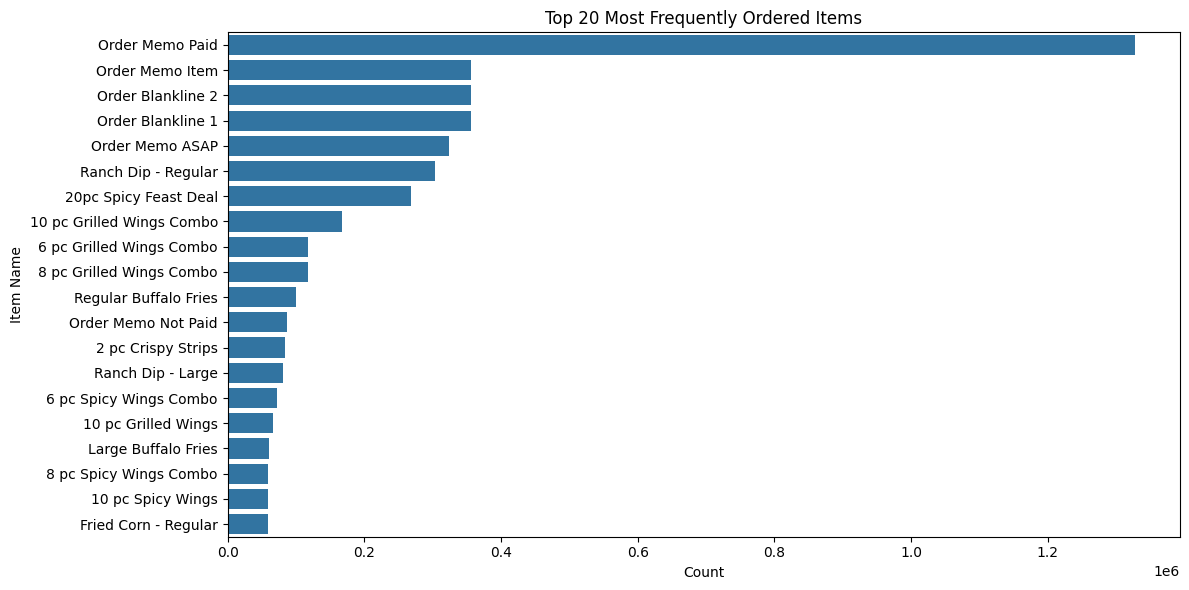

In [ ]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Basic info
print("Unique customers:", order_df['CUSTOMER_ID'].nunique())
print("Unique stores:", store_df['STORE_NUMBER'].nunique())
print("Order channels:", order_df['ORDER_CHANNEL_NAME'].value_counts())
print("Customer types:", customer_df['CUSTOMER_TYPE'].value_counts())

# 🧪 Extract all item names from nested ORDERS column
def extract_items(order_str):
    try:
        data = json.loads(order_str)
        items = []
        for order in data.get("orders", []):
            for item in order.get("item_details", []):
                items.append(item.get("item_name", ""))
        return items
    except:
        return []

order_df['ITEM_LIST'] = order_df['ORDERS'].apply(extract_items)

# 🔝 Top 20 most frequently ordered items
all_items = [item for sublist in order_df['ITEM_LIST'] for item in sublist]
item_freq = Counter(all_items)
top_items = item_freq.most_common(20)

# 📈 Plot Top 20 items
items, counts = zip(*top_items)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(items))
plt.title("Top 20 Most Frequently Ordered Items")
plt.xlabel("Count")
plt.ylabel("Item Name")
plt.tight_layout()
plt.show()


In [ ]:
# Step 4: Clean non-food items from ITEM_LIST

# Define known non-food patterns
non_food_keywords = ['memo', 'blankline', 'asap', 'order']

def is_valid_item(item):
    item = item.lower()
    return not any(keyword in item for keyword in non_food_keywords)

# Cleaned item list per order
order_df['CLEANED_ITEMS'] = order_df['ITEM_LIST'].apply(lambda items: [i for i in items if is_valid_item(i)])

# Filter orders with at least 2 items (for basket analysis)
basket_df = order_df[order_df['CLEANED_ITEMS'].apply(len) >= 2]

# Show sample cleaned baskets
basket_df[['CUSTOMER_ID', 'CLEANED_ITEMS']].head()


,CUSTOMER_ID,CLEANED_ITEMS
0,362204699,"[10 pc Grilled Wings Combo, 8 pc Grilled Wings..."
1,269612955,"[Ranch Dip - Regular, 50 pc Grilled Wings, Reg..."
3,950661333,"[20 pc Grilled Wings, Ranch Dip - Regular]"
4,434985772,"[6 pc Grilled Wings Combo, 8 pc Grilled Wings ..."
6,426992703,"[10 pc Grilled Wings, Ranch Dip - Regular]"


In [ ]:
# Step 1: Clean the data again if needed
import json
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# --- Cleaning Functions ---
non_food_keywords = ['memo', 'blankline', 'asap', 'order']

def extract_items(order_str):
    try:
        data = json.loads(order_str)
        items = []
        for order in data.get("orders", []):
            for item in order.get("item_details", []):
                items.append(item.get("item_name", ""))
        return items
    except:
        return []

def is_valid_item(item):
    item = item.lower()
    return not any(keyword in item for keyword in non_food_keywords)

# --- Cleaned Items Column ---
order_df['ITEM_LIST'] = order_df['ORDERS'].apply(extract_items)
order_df['CLEANED_ITEMS'] = order_df['ITEM_LIST'].apply(lambda items: [i for i in items if is_valid_item(i)])
basket_df = order_df[order_df['CLEANED_ITEMS'].apply(len) >= 2]

print("✅ Cleaned basket_df shape:", basket_df.shape)

# Step 2: Sample 25,000 transactions to avoid memory issues
sampled_baskets = basket_df['CLEANED_ITEMS'].sample(n=25000, random_state=42).tolist()

# Step 3: Transaction Encoding
te = TransactionEncoder()
te_ary = te.fit(sampled_baskets).transform(sampled_baskets)
df_tf = pd.DataFrame(te_ary, columns=te.columns_)

# Step 4: Run Apriori
frequent_itemsets = apriori(df_tf, min_support=0.002, use_colnames=True)

# Step 5: Generate Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by='confidence', ascending=False)

# Step 6: Show Top 10 Rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


✅ Cleaned basket_df shape: (814165, 10)


,antecedents,consequents,support,confidence,lift
312,"(10 pc Spicy Wings, 10 pc Grilled Wings)",(Ranch Dip - Regular),0.00560,0.790960,2.127153
89,(15 pc Mixed Wings),(Ranch Dip - Regular),0.00244,0.782051,2.103193
386,"(Fried Corn - Regular, 10 pc Spicy Wings)",(Ranch Dip - Regular),0.00312,0.780000,2.097676
310,"(10 pc Grilled Wings, 10 pc Grilled Wings Combo)",(Ranch Dip - Regular),0.00376,0.770492,2.072106
332,"(6 pc Grilled Wings Combo, 10 pc Grilled Wings)",(Ranch Dip - Regular),0.00216,0.692308,1.861843
41,(10 pc Mixed Wings),(Ranch Dip - Regular),0.00352,0.676923,1.820469
346,"(Fried Corn - Regular, 10 pc Grilled Wings)",(Ranch Dip - Regular),0.00316,0.675214,1.815872
350,"(Large Buffalo Fries, 10 pc Grilled Wings)",(Ranch Dip - Regular),0.00424,0.650307,1.748889
8,(10 pc Grilled Wings),(Ranch Dip - Regular),0.04720,0.644457,1.733156
126,(20 pc Spicy Wings),(Ranch Dip - Regular),0.00296,0.643478,1.730525


In [ ]:
def recommend_items(cart_items, rules_df, top_k=3):
    cart_items = set(cart_items)
    scored_recos = []

    for _, row in rules_df.iterrows():
        antecedent = set(row['antecedents'])
        consequent = list(row['consequents'])[0]

        # Skip if consequent already in cart
        if consequent in cart_items:
            continue

        # Compute overlap (match ratio)
        overlap = len(cart_items.intersection(antecedent))
        if overlap == 0:
            continue

        match_ratio = overlap / len(antecedent)

        # Combined score: confidence × lift × match_ratio
        score = row['confidence'] * row['lift'] * match_ratio

        scored_recos.append((consequent, score))

    # Sort by combined score
    scored_recos.sort(key=lambda x: x[1], reverse=True)

    # Return top-k unique recommendations
    recommended_items = []
    for item, _ in scored_recos:
        if item not in recommended_items:
            recommended_items.append(item)
        if len(recommended_items) == top_k:
            break

    return recommended_items


In [ ]:
sample_cart = ["10 pc Spicy Wings", "10 pc Grilled Wings"]
recommend_items(sample_cart, rules)


['Ranch Dip - Regular', 'Regular Buffalo Fries', 'Blue Cheese Dip - Regular']

In [ ]:
print(test_df.columns.tolist())


['CUSTOMER_ID', 'STORE_NUMBER', 'ORDER_ID', 'ORDER_CHANNEL_NAME', 'ORDER_SUBCHANNEL_NAME', 'ORDER_OCCASION_NAME', 'CUSTOMER_TYPE', 'item1', 'item2', 'item3']


In [ ]:
# Function to extract cart items
def get_cart_items(row):
    return [item for item in [row['item1'], row['item2'], row['item3']] if pd.notna(item)]

# Generate recommendations
output_rows = []

for _, row in test_df.iterrows():
    cart = get_cart_items(row)
    recos = recommend_items(cart, rules, top_k=3)

    output_rows.append({
        'CUSTOMER_ID': row['CUSTOMER_ID'],
        'ORDER_ID': row['ORDER_ID'],
        'item1': row.get('item1', ''),
        'item2': row.get('item2', ''),
        'item3': row.get('item3', ''),
        'RECOMMENDATION 1': recos[0] if len(recos) > 0 else '',
        'RECOMMENDATION 2': recos[1] if len(recos) > 1 else '',
        'RECOMMENDATION 3': recos[2] if len(recos) > 2 else ''
    })

# Save to Excel
submission_df = pd.DataFrame(output_rows)
submission_df.to_excel("/content/WWT_DataAchievers.xlsx", index=False)

print("✅ Output Excel file saved successfully!")


✅ Output Excel file saved successfully!
